# Capstone Project workbook - Allie Garrison


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
conn = sqlite3.connect('zippedData/im.db')

bom_movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
rt_movie_info = pd.read_csv("zippedData/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t',encoding='windows-1252')
tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv")
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", parse_dates=['release_date'])

In [ ]:
rt_reviews.head()

In [ ]:
rt_reviews.info()

In [ ]:
bom_movie_gross.info()

In [ ]:
bom_movie_gross.head()

In [ ]:
rt_movie_info.info()

In [ ]:
rt_movie_info.head()

In [ ]:
tmdb_movies.info()

In [ ]:
tmdb_movies.head()

In [1]:
tn_movie_budgets.info()

NameError: name 'tn_movie_budgets' is not defined

In [ ]:
tn_movie_budgets.head()

In [ ]:
tn_movie_budgets.plot.bar('production_budget')

In [3]:
## Making copy of movie budgets data frame for cleaning
tn_movie_budgets_clean = tn_movie_budgets.copy()

## turning the columns with dollar amounts into int types in millions of dollars
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross_in_millions'].astype('int64') / 1000000

## keeping only the movies released after January 1, 2010
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['release_date'] >= "2010-01-01"]

## removing all the movies that made $0
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['domestic_gross_in_millions'] != 0]

In [ ]:
## Calculating return on investment (ROI) for domestic and international revenue
tn_movie_budgets_clean['ROI_domestic'] = (tn_movie_budgets_clean['domestic_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean['ROI_international'] = (tn_movie_budgets_clean['worldwide_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean.head()

In [ ]:
q = '''
SELECT *
FROM persons
LEFT JOIN known_for k USING (person_id)
LEFT JOIN movie_basics m USING (movie_id)

'''

pd.read_sql(q, conn)

In [ ]:
pd.read_sql('''
SELECT  genres, COUNT() AS count_of_genres
FROM movie_basics
GROUP BY genres
ORDER BY count_of_genres DESC
''', conn)

In [7]:
table3 = pd.read_sql('''
SELECT  title
FROM movie_akas
WHERE is_original_title = 1

''', conn)

### 

In [9]:
## Joining the cleaned budget dataframe onto a queried dataframe from sql database on movie title
budget_w_sql = tn_movie_budgets_clean.merge(table3, how='inner', left_on='movie', right_on='title')

In [11]:
budget_w_sql.describe()

id  production_budget_in_millions  domestic_gross_in_millions  \
count  1608.000000                    1608.000000                 1608.000000   
mean     51.268657                      44.242343                   55.748024   
std      28.586335                      54.611218                   81.857288   
min       1.000000                       0.009000                    0.000388   
25%      27.000000                       9.000000                    5.028911   
50%      51.000000                      25.000000                   28.789233   
75%      76.250000                      55.000000                   67.098325   
max     100.000000                     410.600000                  700.059566   

       worldwide_gross_in_millions  ROI_domestic  ROI_international  
count                  1608.000000   1608.000000        1608.000000  
mean                    139.093446    210.463647         417.476241  
std                     224.332319    677.747145        1247.748458  
min                       0.000528      0.003060           0.013800  
25%                      11.463160     38.193487          96.451485  
50%                      54.398944     96.800197         224.235561  
75%                     157.464832    207.513787         412.027695  
max                    2048.134200  22764.410000       41656.474000

In [13]:
table_genre = pd.read_sql('''
SELECT mb.primary_title, 
        mb.runtime_minutes, 
        mb.genres, 
        mr.averagerating,
        mr.numvotes
FROM movie_basics AS mb
JOIN movie_ratings AS mr USING (movie_id)
''', conn)

In [14]:
genre_ratings_budget = tn_movie_budgets_clean.merge(table_genre, how='inner', left_on='movie', right_on='primary_title')

In [15]:
genre_ratings_budget.head()

id release_date                                        movie  \
0   2   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
1   3   2019-06-07                                 Dark Phoenix   
2   4   2015-05-01                      Avengers: Age of Ultron   
3   7   2018-04-27                       Avengers: Infinity War   
4   9   2017-11-17                               Justice League   

  production_budget domestic_gross worldwide_gross  \
0      $410,600,000   $241,063,875  $1,045,663,875   
1      $350,000,000    $42,762,350    $149,762,350   
2      $330,600,000   $459,005,868  $1,403,013,963   
3      $300,000,000   $678,815,482  $2,048,134,200   
4      $300,000,000   $229,024,295    $655,945,209   

   production_budget_in_millions  domestic_gross_in_millions  \
0                          410.6                  241.063875   
1                          350.0                   42.762350   
2                          330.6                  459.005868   
3                          300.0                  678.815482   
4                          300.0                  229.024295   

   worldwide_gross_in_millions  ROI_domestic  ROI_international  \
0                  1045.663875     58.710150         254.667286   
1                   149.762350     12.217814          42.789243   
2                  1403.013963    138.840250         424.384139   
3                  2048.134200    226.271827         682.711400   
4                   655.945209     76.341432         218.648403   

                                 primary_title  runtime_minutes  \
0  Pirates of the Caribbean: On Stranger Tides            136.0   
1                                 Dark Phoenix            113.0   
2                      Avengers: Age of Ultron            141.0   
3                       Avengers: Infinity War            149.0   
4                               Justice League            120.0   

                     genres  averagerating  numvotes  
0  Action,Adventure,Fantasy            6.6    447624  
1   Action,Adventure,Sci-Fi            6.0     24451  
2   Action,Adventure,Sci-Fi            7.3    665594  
3   Action,Adventure,Sci-Fi            8.5    670926  
4  Action,Adventure,Fantasy            6.5    329135

In [16]:
genre_ratings_budget.describe()

id  production_budget_in_millions  domestic_gross_in_millions  \
count  1843.000000                    1843.000000                 1843.000000   
mean     51.271297                      43.340034                   55.352753   
std      28.849608                      53.914519                   82.861029   
min       1.000000                       0.009000                    0.000388   
25%      27.000000                       9.000000                    4.050486   
50%      51.000000                      22.000000                   27.695246   
75%      77.000000                      52.000000                   67.061228   
max     100.000000                     410.600000                  700.059566   

       worldwide_gross_in_millions  ROI_domestic  ROI_international  \
count                  1843.000000   1843.000000        1843.000000   
mean                    137.497935    203.748145         405.027100   
std                     226.631164    632.528092        1164.718885   
min                       0.000528      0.003060           0.013800   
25%                      11.329520     35.245969          91.314365   
50%                      52.460543     94.733433         220.585212   
75%                     152.417957    205.204881         409.060377   
max                    2048.134200  22764.410000       41656.474000   

       runtime_minutes  averagerating      numvotes  
count      1803.000000    1843.000000  1.843000e+03  
mean        106.063783       6.379870  9.819755e+04  
std          19.685396       1.044827  1.544851e+05  
min           3.000000       1.600000  5.000000e+00  
25%          93.000000       5.800000  4.725500e+03  
50%         104.000000       6.500000  4.215400e+04  
75%         117.000000       7.100000  1.187285e+05  
max         280.000000       9.200000  1.841066e+06

<AxesSubplot:>

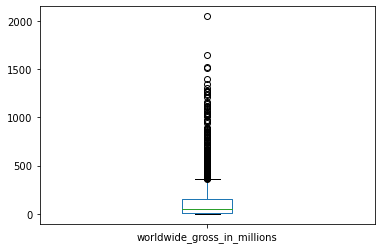

In [20]:
genre_ratings_budget.worldwide_gross_in_millions.plot.box()